In [1]:
import sys,os,glob,copy
sys.path.append('../')
import numpy as np
from statistics import median, mean
from numpy.linalg import norm
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.interpolate import LinearNDInterpolator,interp2d, griddata
from itertools import product
import matplotlib as mpl
from matplotlib.colors import LogNorm
from IPython.display import display, Markdown
import glob
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')


pd.set_option('display.max_rows', 200)

### Load Recast Data

In [2]:
# Load models (axial and vector)
inputFiles = ['../axial_nocut.pcl',
              '../vector_nocut.pcl']

dfs = [pd.read_pickle(i) for i in inputFiles]
recastData = pd.concat(dfs, ignore_index=True)

### Get model points

In [3]:
models = []
mCols = ['Coupling', 'Mode', '$m_{med}$', '$m_{DM}$']
for row in recastData[mCols].values:
    m = dict(zip(mCols, row.tolist()))
    if m not in models:
        models.append(m)

print('%i models loaded.' %len(models))

210 models loaded.


### Get model parameters

In [4]:
parameters = {label : list(set([m[label] for m in models])) for label in mCols}
for k,v in parameters.items():
    if len(v) == 1:
        parameters[k] = v[0]
print(parameters)

textstr = '\n'.join([r'%s = %s' %(k,v) for k,v in parameters.items() if k not in ['$m_{med}$','$m_{DM}$']])
print(textstr)

{'Coupling': ['Vector', 'Axial'], 'Mode': 'DM+QCDjets', '$m_{med}$': [10.0, 145.0, 295.0, 300.0, 3000.0, 2750.0, 2500.0, 2250.0, 1995.0, 2000.0, 1750.0, 1500.0, 1250.0, 995.0, 100.0, 1000.0, 750.0, 500.0, 250.0], '$m_{DM}$': [1000.0, 10.0, 300.0, 750.0, 1200.0, 500.0, 150.0, 1400.0]}
Coupling = ['Vector', 'Axial']
Mode = DM+QCDjets


### Obtain Efficiencies

In [5]:
label = [c for c in recastData if (c.startswith("bin_") and not 'Error' in c)]

for l in label:
    ns = recastData[l]
    nsErr = recastData[f'{l}_ErrorPlus']
    lumi = recastData['Luminosity (1/fb)']
    xsec = recastData['Total xsec (pb)']
    recastData[f'{l}_Efficiency'] = ns/(1e3*xsec*lumi)
    recastData[f'{l}_Efficiency_Error'] = nsErr*(recastData[f'{l}_Efficiency'])/ns
    recastData[f'{l}_Efficiency_Error'] = recastData[f'{l}_Efficiency_Error'].replace(np.nan, 0)
    

In [6]:
# Select year
recastData = recastData[recastData['Data-takingperiod'] == 2017]

In [7]:
recastData.T

,1,4,7,10,13,16,19,22,25,28,...,601,604,607,610,613,616,619,622,625,628
Coupling,Axial,Axial,Axial,Axial,Axial,Axial,Axial,Axial,Axial,Axial,...,Vector,Vector,Vector,Vector,Vector,Vector,Vector,Vector,Vector,Vector
Mode,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets,...,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets
$m_{med}$,10.0,10.0,10.0,10.0,10.0,10.0,10.0,100.0,100.0,145.0,...,2750.0,2750.0,3000.0,3000.0,3000.0,3000.0,3000.0,3000.0,3000.0,3000.0
$m_{DM}$,150.0,300.0,500.0,750.0,1000.0,1200.0,1400.0,10.0,750.0,300.0,...,1200.0,1400.0,10.0,150.0,300.0,500.0,750.0,1000.0,1200.0,1400.0
Data-takingperiod,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,...,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017
Luminosity (1/fb),41.5,41.5,41.5,41.5,41.5,41.5,41.5,41.5,41.5,41.5,...,41.5,41.5,41.5,41.5,41.5,41.5,41.5,41.5,41.5,41.5
bin_250.0_280.0,468.973762,52.835113,6.082364,0.772232,0.131228,0.041094,0.010609,251953.438529,0.841252,55.622491,...,21.436877,2.499204,20.035738,19.05971,19.387503,16.94368,16.689991,14.997237,12.629858,8.659639
bin_250.0_280.0_ErrorPlus,23.776352,2.809688,0.285839,0.033785,0.006432,0.002239,0.000965,18147.681166,0.038982,3.12279,...,1.112332,0.142456,1.185906,1.1258,1.083263,0.96634,0.9249,0.840843,0.735811,0.497778
bin_250.0_280.0_ErrorMinus,23.776352,2.809688,0.285839,0.033785,0.006432,0.002239,0.000965,18147.681166,0.038982,3.12279,...,1.112332,0.142456,1.185906,1.1258,1.083263,0.96634,0.9249,0.840843,0.735811,0.497778
bin_280.0_310.0,320.719673,37.64076,4.984899,0.639403,0.119099,0.02901,0.00915,124976.191148,0.642424,42.46079,...,13.92186,1.794896,14.767923,13.315663,14.970176,13.474234,12.439721,11.482995,9.340146,6.496937


In [8]:
mCols = ['$m_{med}$','$m_{DM}$']
dataAx = recastData[recastData['Coupling'] == 'Axial']
dataVec = recastData[recastData['Coupling'] == 'Vector']

In [9]:
keys = list(dataAx[mCols].columns.values)
i1 = dataAx.set_index(keys).index
i2 = dataVec.set_index(keys).index
dataAx = dataAx[i1.isin(i2)]
dataVec = dataVec[i2.isin(i1)]
# i3 = effPseudo.set_index(keys).index
print(len(dataAx),len(dataVec))

103 103


In [10]:
# Setting the index with mass pairs
effAx = pd.DataFrame([dataAx.set_index(['$m_{med}$', '$m_{DM}$'])[c] for c in recastData if 'Efficiency' in c])
effVec = pd.DataFrame([dataVec.set_index(['$m_{med}$', '$m_{DM}$'])[c] for c in recastData if 'Efficiency' in c])

In [11]:
# Reduced chi squared statistics
maxDiff = []
chis = []
for med, dm in effVec:
    rd = np.abs(effAx[med,dm].iloc[::2] - effVec[med,dm].iloc[::2])/effAx[med,dm].iloc[::2]
    rd = rd.replace(np.inf, 0)
    rd = rd.max()
    d = (effAx[med,dm].iloc[::2] - effVec[med,dm].iloc[::2])**2
    d = d.replace(np.inf, 0)
    errd = effAx[med,dm].iloc[1::2]**2 + effVec[med,dm].iloc[1::2]**2
    errd = errd.replace(np.inf, 0)
    chi = []
    for i in range(len(d)):
        if d[i] == 0:
            chi.append(0)
        else:
            chi.append(d[i]/errd[i])
    
#     chi = [d[i]/errd[i] for i in range(len(d))]
#     chi = [0 if np.isnan(i) else i for i in chi]
    chis.append(sum(chi)/len(d))
    maxDiff.append(rd)
    

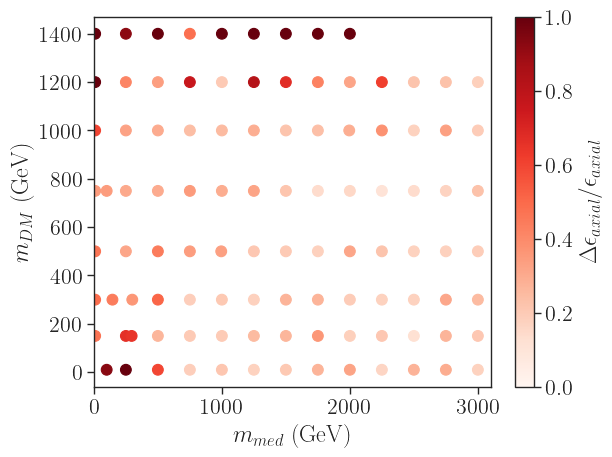

In [12]:
# Plot results
plt.scatter(x=dataVec['$m_{med}$'], y=dataVec['$m_{DM}$'], vmin=0., vmax=1., c=maxDiff, 
            cmap=plt.cm.get_cmap('Reds'), s=60)

cbar=plt.colorbar(label=r'$\Delta \epsilon_{axial}/\epsilon_{axial}$')
plt.xlabel(r'$m_{med}$ (GeV)')
plt.xlim(0,3100)
plt.ylabel(r'$m_{DM}$ (GeV)')
# plt.ylim(-10,1500)
plt.show()

In [13]:
pts = np.array([x for x in product(np.linspace(0.,3000.,100),np.linspace(0.,1500.,100))])
relDiffPts = griddata(list(zip(dataVec['$m_{med}$'],dataVec['$m_{DM}$'])),
                  maxDiff,pts)
pts = pts[~np.isnan(relDiffPts)]
relDiffPts = relDiffPts[~np.isnan(relDiffPts)]

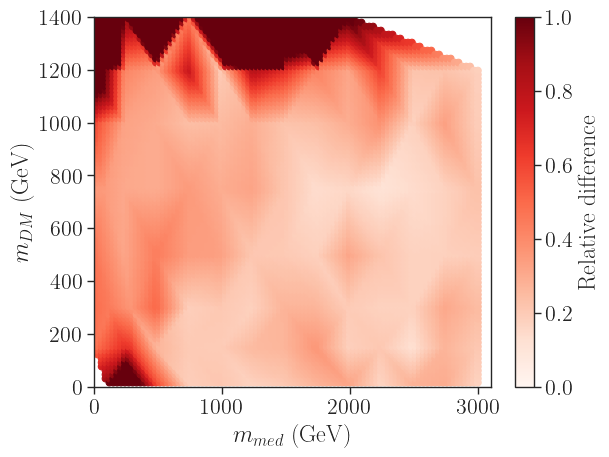

In [14]:
plt.scatter(x=pts[:,0], y=pts[:,1], vmin=0., vmax =1., 
            c=relDiffPts, cmap=plt.cm.get_cmap('Reds'))
cbar = plt.colorbar(label='Relative difference')


plt.xlabel(r'$m_{med}$ (GeV)')
plt.xlim(0,3100)
plt.ylabel(r'$m_{DM}$ (GeV)')
plt.ylim(0,1400)
plt.show()

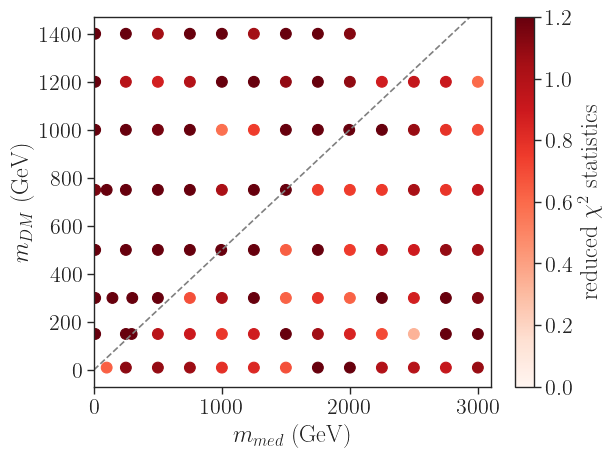

In [15]:
# Plot results
plt.scatter(x=dataVec['$m_{med}$'], y=dataVec['$m_{DM}$'], vmin=0., vmax=1.2, c=chis, 
            cmap=plt.cm.get_cmap('Reds'), s=60)

cbar=plt.colorbar(label=r'reduced $\chi^{2}$ statistics')
plt.axline((1, 1), slope=1/2, linestyle='--', color='gray')
plt.xlabel(r'$m_{med}$ (GeV)')
plt.xlim(0,3100)
plt.ylabel(r'$m_{DM}$ (GeV)')
# plt.ylim(-10,1500)
plt.show()

In [16]:
chisPts = griddata(list(zip(dataVec['$m_{med}$'],dataVec['$m_{DM}$'])),
                  chis,pts)
ptsChi = pts[~np.isnan(chisPts)]
chisPts = chisPts[~np.isnan(chisPts)]

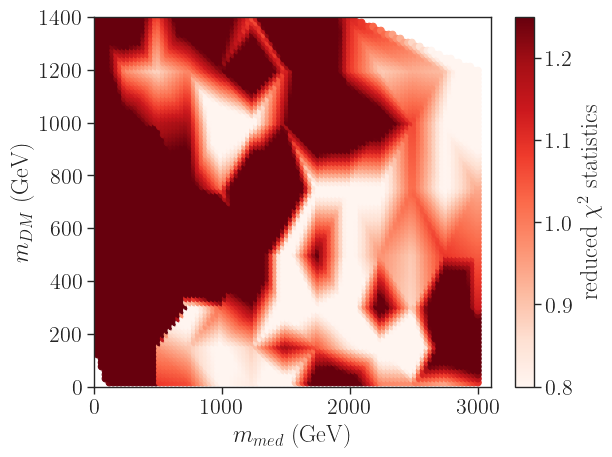

In [17]:
plt.scatter(x=ptsChi[:,0], y=ptsChi[:,1], vmin=0.8, vmax =1.25, 
            c=chisPts, cmap=plt.cm.get_cmap('Reds'))
cbar = plt.colorbar(label=r'reduced $\chi^{2}$ statistics')


plt.xlabel(r'$m_{med}$ (GeV)')
plt.xlim(0,3100)
plt.ylabel(r'$m_{DM}$ (GeV)')
plt.ylim(0,1400)
plt.show()

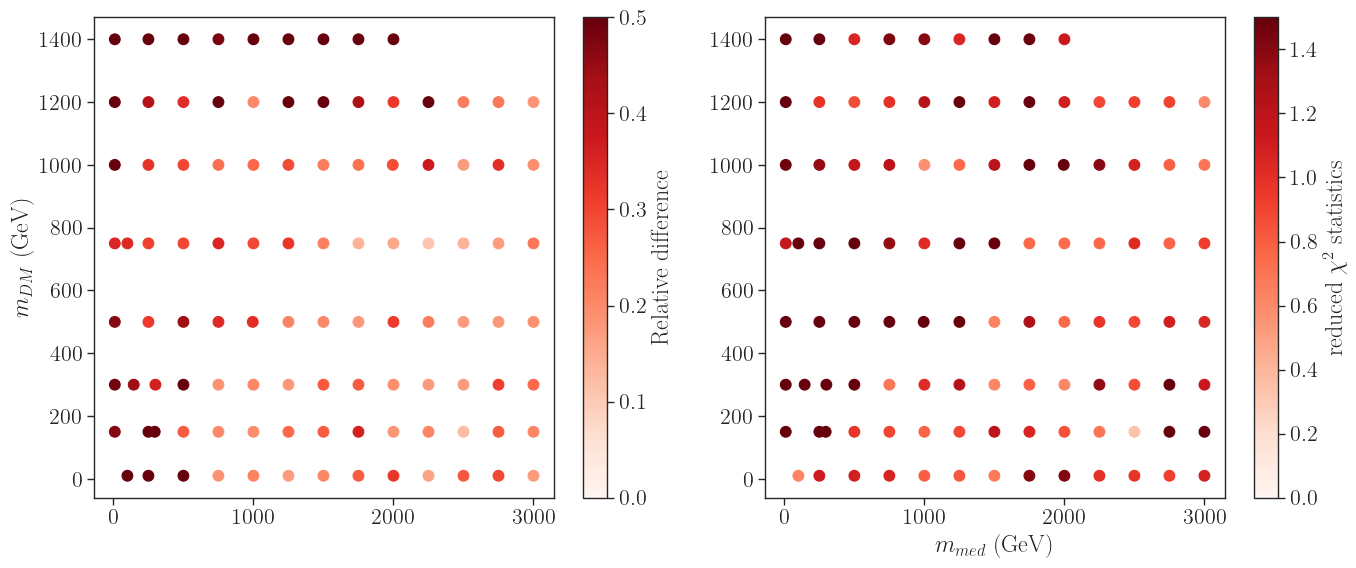

In [18]:
fig,ax = plt.subplots(figsize=(14,6),ncols=2,nrows=1)

p1 = ax[0].scatter(x=dataVec['$m_{med}$'], y=dataVec['$m_{DM}$'], vmin=0., vmax=.5, c=maxDiff, 
            cmap=plt.cm.get_cmap('Reds'), s=60)

p2 = ax[1].scatter(x=dataVec['$m_{med}$'], y=dataVec['$m_{DM}$'], vmin=0., vmax=1.5, c=chis, 
             cmap=plt.cm.get_cmap('Reds'), s=60)

ax[0].set_ylabel(r'$m_{DM}$ (GeV)')
ax[1].set_xlabel(r'$m_{med}$ (GeV)')

cbar1 = plt.colorbar(p1, label='Relative difference', ax=ax[0])
cbar2 = plt.colorbar(p2, label=r'reduced $\chi^{2}$ statistics', ax=ax[1])
plt.tight_layout()
plt.show()

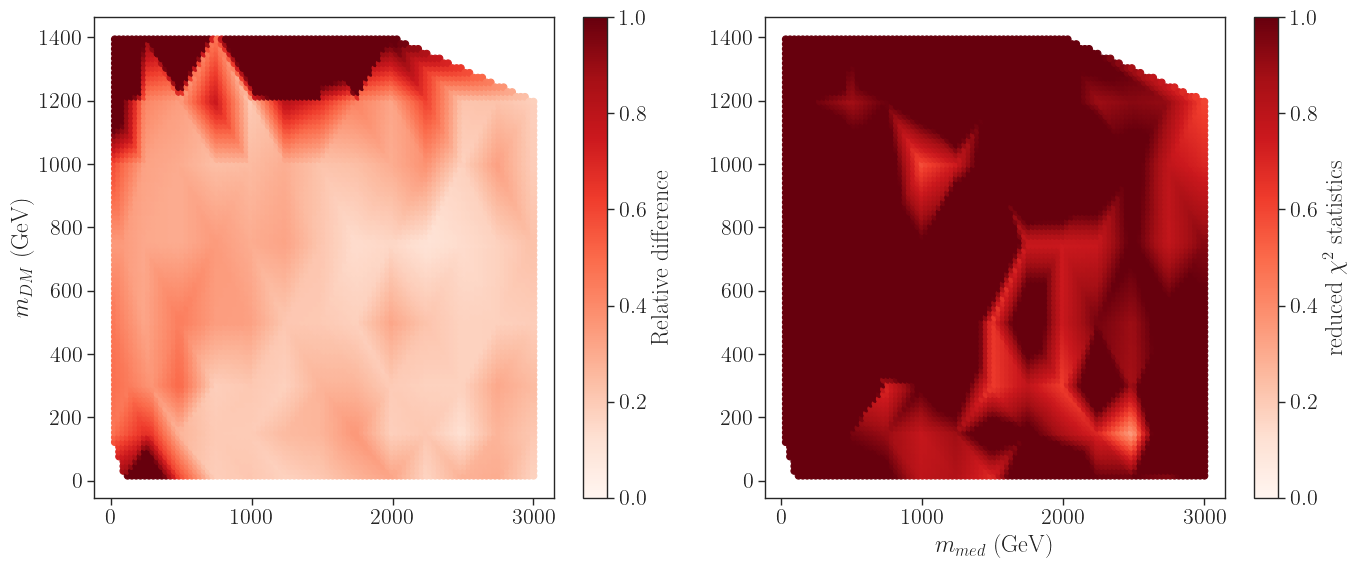

In [19]:
fig,ax = plt.subplots(figsize=(14,6),ncols=2,nrows=1)

p1 = ax[0].scatter(x=pts[:,0], y=pts[:,1], vmin=0., vmax =1., c=relDiffPts, cmap=plt.cm.get_cmap('Reds'))
# ax[0].axline((1, 1), slope=1/2, linestyle='--', color='gray')

p2 = ax[1].scatter(x=ptsChi[:,0], y=ptsChi[:,1], vmin=0., vmax =1., c=chisPts, cmap=plt.cm.get_cmap('Reds'))

ax[0].set_ylabel(r'$m_{DM}$ (GeV)')
ax[1].set_xlabel(r'$m_{med}$ (GeV)')

cbar1 = plt.colorbar(p1, label='Relative difference', ax=ax[0])
cbar2 = plt.colorbar(p2, label=r'reduced $\chi^{2}$ statistics', ax=ax[1])
plt.tight_layout()
plt.show()

In [20]:
diff2 = []
for med, dm in effVec:
    d = np.abs(effAx[med, dm] - effVec[med, dm])/effAx[med, dm]
    d = d.replace(np.inf, 0)
    d2 = np.sort(d)
    d = d.max()
    d2 = d2[:-2].max()
    diff2.append((d-d2)/2)

In [21]:
pts = np.array([x for x in product(np.linspace(0.,3000.,100),np.linspace(0.,1500.,100))])
relDiffPts = griddata(list(zip(dataVec['$m_{med}$'],dataVec['$m_{DM}$'])),
                  diff2,pts)
pts = pts[~np.isnan(relDiffPts)]
relDiffPts = relDiffPts[~np.isnan(relDiffPts)]

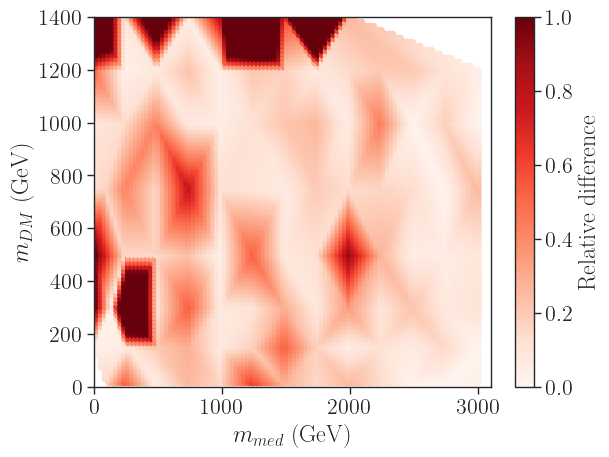

In [22]:
plt.scatter(x=pts[:,0], y=pts[:,1], vmin=0., vmax =1., 
            c=relDiffPts, cmap=plt.cm.get_cmap('Reds'))
cbar = plt.colorbar(label='Relative difference')


plt.xlabel(r'$m_{med}$ (GeV)')
plt.xlim(0,3100)
plt.ylabel(r'$m_{DM}$ (GeV)')
plt.ylim(0,1400)
plt.show()